In [1]:
%cd ..

d:\work\ADASVehicleTracking


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import matplotlib.pyplot as plt
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# !wget https://www.livemint.com/rf/Image-621x414/LiveMint/Period1/2012/10/01/Photos/Road621.jpg
img_path = 'data/Road621.jpg'

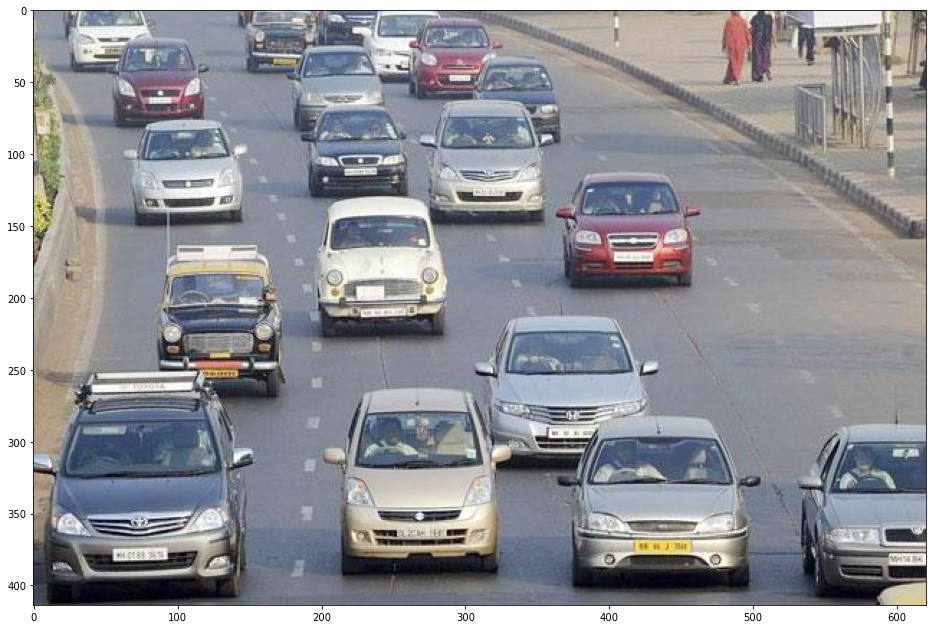

In [4]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,18))
plt.imshow(img)

In [5]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def props(img,show_uniques=False):
    print("Shape :",img.shape,"Maximum :",img.max(),"Minimum :",img.min(),"Data Type :",img.dtype)
    if show_uniques:
        print("Uniques :",np.unique(img))

def show_image(img,title=None, convert_BGR2RGB=True, figure_size = (20,15)):
    img = np.squeeze(img)
    plt.figure(figsize=figure_size)
    plt.axis('off')
    plt.imshow(img)
    if title:
        save_path = f"visualizations/{title}.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if convert_BGR2RGB:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # if modified_image.shape[2] == 1:
        #     modified_image = cv2.cvtColor(modified_image, cv2.COLOR_GRAY2RGB)
        img = img / img.max()
        img = img * 255
        cv2.imwrite(save_path, img.astype(np.uint8))
        # cv2.imwrite(save_path, modified_image.astype(np.int8))
        # plt.savefig(save_path, dpi = 600)
    plt.show()

def get_cluster_images_separated(image, default_background_fill_value = 0, save = True, prepend_save = "GMM_cluster_"):
    uniques = np.unique(image)
    # if default_background_fill_value == "plus_one":
    #     background_fill_value = max(uniques) + 1
    cluster_images = []
    for unique in uniques: # [0, 1, 2]
        current_image = np.where(image == unique, 1, default_background_fill_value)
        cluster_images.append(current_image)
        if save:
            save_path = f"visualizations/{prepend_save}{unique}.png"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # modified_image = cv2.cvtColor(current_image, cv2.COLOR_GRAY2RGB)
            # current_image = cv2.cvtColor(current_image, cv2.COLOR_RGB2BGR)
            # if modified_image.shape[2] == 1:
            #     modified_image = cv2.cvtColor(modified_image, cv2.COLOR_GRAY2RGB)
            current_image = current_image / current_image.max()
            current_image = current_image * 255
            cv2.imwrite(save_path, current_image.astype(np.uint8))
        
    return cluster_images
    # print(i)
    
def readImage(image_path = None, img_data = None, convert_BGR2RGB = True, grayscale = False):
    if image_path is not None:
        if grayscale:
            img_data = cv2.imread(image_path, 0)
            # img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        else:
            img_data = cv2.imread(image_path)
    if convert_BGR2RGB and not grayscale:
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    return img_data

def save_image_cmap(image, title = None, cmap = "viridis"):
    # a colormap and a normalization instance
    try:
        cmap = eval(f"plt.cm.{cmap}")
    except:
        print(f"ERROR, cmap should be one of the following : {dir(plt.cm)}")
        print("Defaulting to viridis")
        cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=image.min(), vmax=image.max())
    
    # map the normalized data to colors
    # image is now RGBA (X x Y x 4) 
    image = cmap(norm(image))
    
    if image.max() == 1:
        image = np.squeeze( image * 255)
    image = image.astype(np.uint8)
    cv2.imwrite(f'visualizations/{title}.png',image )
    return image

In [6]:
# python GMM/coarse_clustering.py -i ../data/GMM/GMM_data.csv -o ../data/GMM/GMM_coarse_clustering.csv -k 3

from sklearn.mixture import GaussianMixture
import numpy as np
import cv2
# from utils import readImage


def run_GMM_clustering(image_path = None, img_data = None, convert_BGR2RGB = True,  k = 3, covariance_type="tied"):  
    """Run the GMM Clustering Algorithm on an Image.

    Args:
        image_path (str, optional): Path to the image. Defaults to None.
        img_data (np.array, optional): Array of the Image read by Numpy/CV2. Defaults to None.
        convert_BGR2RGB (bool, optional): Convert the BGR image to RGB. Defaults to True.
        k (int, optional): The number of clusters for which clustering will be performed. Defaults to 3.
        covariance_type (str, optional): Parameter for GMM from sklearn. Defaults to "tied", "full".
        # TODO :  Add GMM_vars = {} to the input!

    Returns:
        np.array: Clustered GMM Image
    """
    if image_path:
        img_data = readImage(image_path=image_path, convert_BGR2RGB=convert_BGR2RGB)
    if k == "elbow_method":
        k = 4 # TODO - Implement the elbow method

    reshaped_img_data = img_data.reshape(img_data.shape[0]*img_data.shape[1], img_data.shape[2])
    gmm = GaussianMixture(n_components = k, covariance_type = covariance_type)
    gmm = gmm.fit(reshaped_img_data)
    
    cluster = gmm.predict(reshaped_img_data)
    retransformed_clustered_image = cluster.reshape(img_data.shape[0], img_data.shape[1], 1).astype(np.uint8)
    # plt.imshow(retransformed_clustered_image)
    return retransformed_clustered_image

In [7]:
import cv2
import numpy as np
# from utils import readImage, props

# https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

def run_CCL_clustering(image_path = None, img_data = None, convert_BGR2RGB = True, connectivity = 4, normalize_labels = True):
    if image_path is not None:
        img_data = readImage(image_path=image_path, grayscale=True, convert_BGR2RGB = convert_BGR2RGB)
    if img_data.max() <= 1:
        img_data = np.uint8(img_data * 255)
    # props(img_data)
    
    thresh_val, thresh_img = cv2.threshold(img_data, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    print(f"thresh_val: {thresh_val}")
    
    # props(thresh_img)
    
    (numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(thresh_img, connectivity, cv2.CV_32S)
    
    print(f"Number of labels: {numLabels} found!")
    print(f"Properties of Statistics (stats)")
    props(stats)
    print(f"Properties of centroids:")
    props(centroids)
    print(f"Properties of Labels :")
    props(labels)
    
    if normalize_labels:
        labels = labels/ np.max(labels) * 255
    
    return labels

def run_CCL_clustering_old(image_path = None, img_data = None, convert_BGR2RGB = True,):
    # props(img_data)
    if image_path is not None:
        img_data = readImage(image_path=image_path,
                             grayscale=True, convert_BGR2RGB = convert_BGR2RGB)
    if img_data.max() <= 1:
        img_data = np.uint8(img_data * 255)
    # props(img_data)
    
    # img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2GRAY)
    img = cv2.threshold(img_data, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels_im = cv2.connectedComponents(img)
    # return num_labels, labels_im
    
    label_hue = np.uint8(179*labels_im/np.max(labels_im))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    return labeled_img

In [8]:
import cv2
import numpy as np

def run_morphological_external_transform(image_path = None, img_data = None):
    if image_path is not None:
        img_data = readImage(image_path=image_path,
                             grayscale=True)
    if img_data.max() <= 1:
        img_data = np.uint8(img_data * 255)
    image_shape = img_data.shape
    if len(image_shape) == 3:
        if image_shape[2] != 1:
            img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2GRAY)
    # props(img_data)
    
    # binarize the image
    binr = cv2.threshold(img_data, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # define the kernel
    kernel = np.ones((3, 3), np.uint8)
    
    # invert the image
    invert = cv2.bitwise_not(binr)

    # use morph gradient
    morph_gradient = cv2.morphologyEx(invert,
                                    cv2.MORPH_GRADIENT,
                                    kernel)
    
    # print the output
    # plt.imshow(morph_gradient, cmap='gray')
    # show_image(morph_gradient, "Morph_gradient", figure_size=(5,5))
    return morph_gradient

In [9]:
num_of_clustering = 4

gmm_image = run_GMM_clustering(img_data = img, k = num_of_clustering)

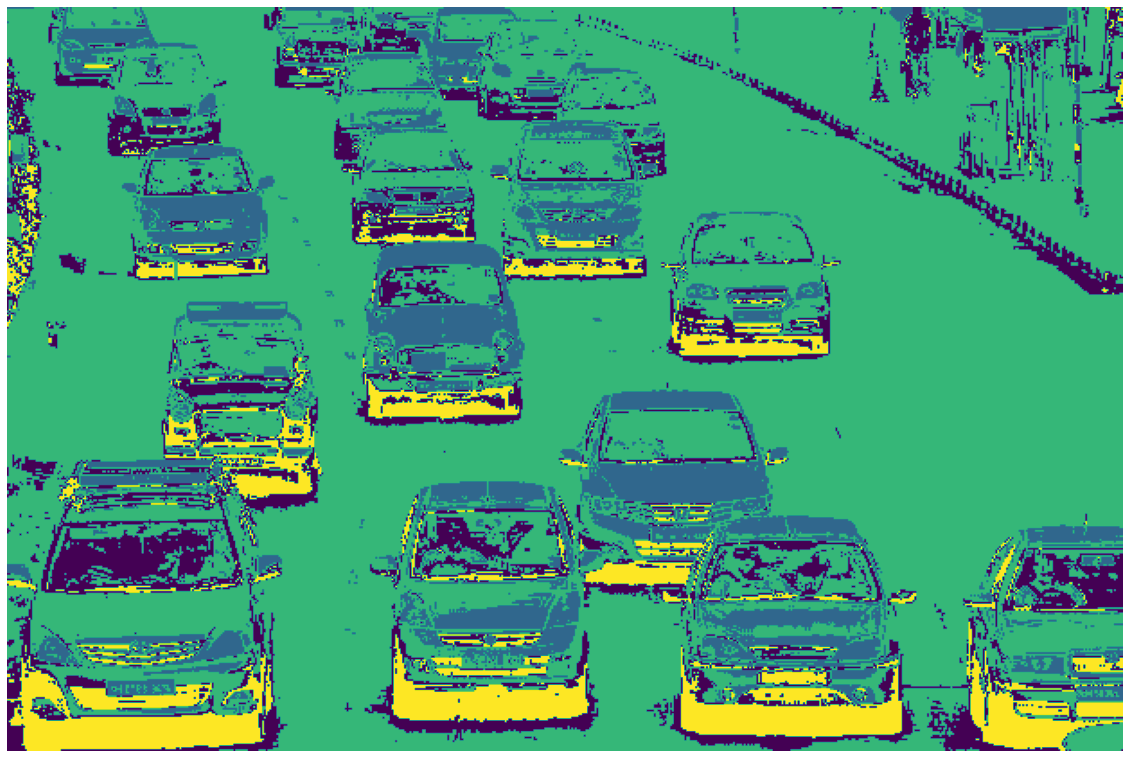

In [10]:
show_image(gmm_image, title = f"GMM_image_k_{num_of_clustering}")

In [11]:
all_GMM_clustered_images = get_cluster_images_separated(gmm_image, save = True, prepend_save = f"GMM_image_k{num_of_clustering}_");

In [12]:
all_CCL_clustered_images = list(map(lambda x: run_CCL_clustering_old(img_data = np.squeeze(x), convert_BGR2RGB=False), all_GMM_clustered_images))

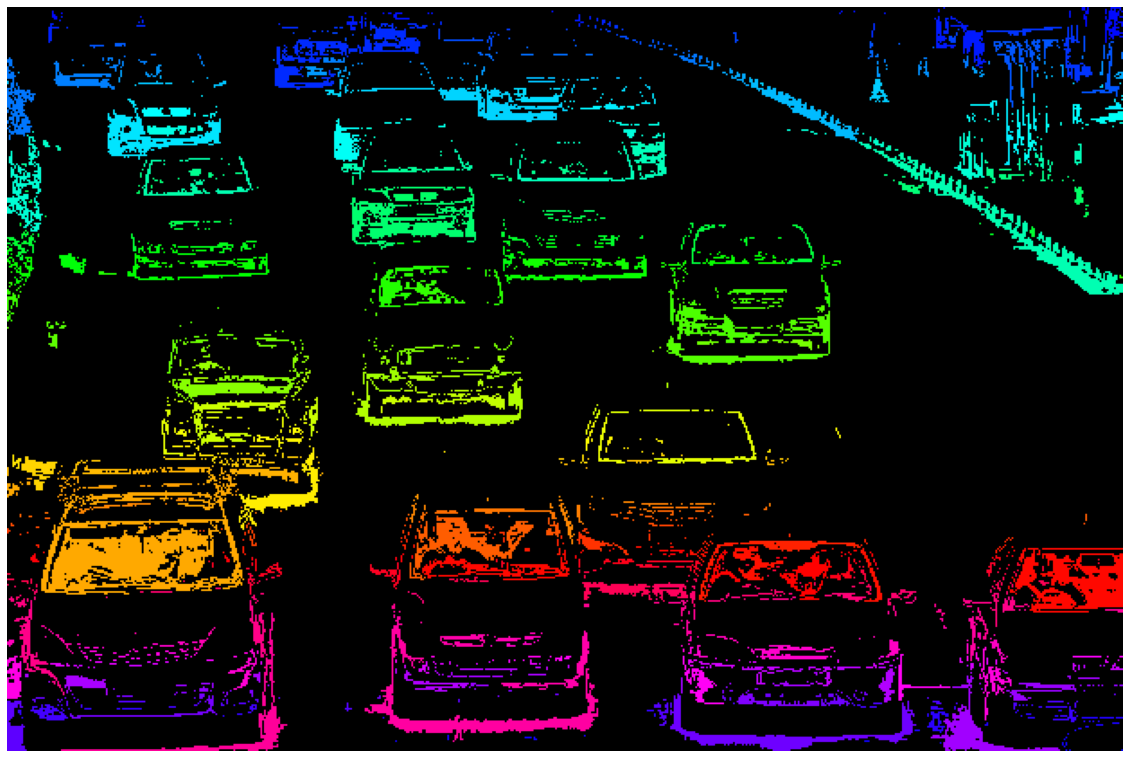

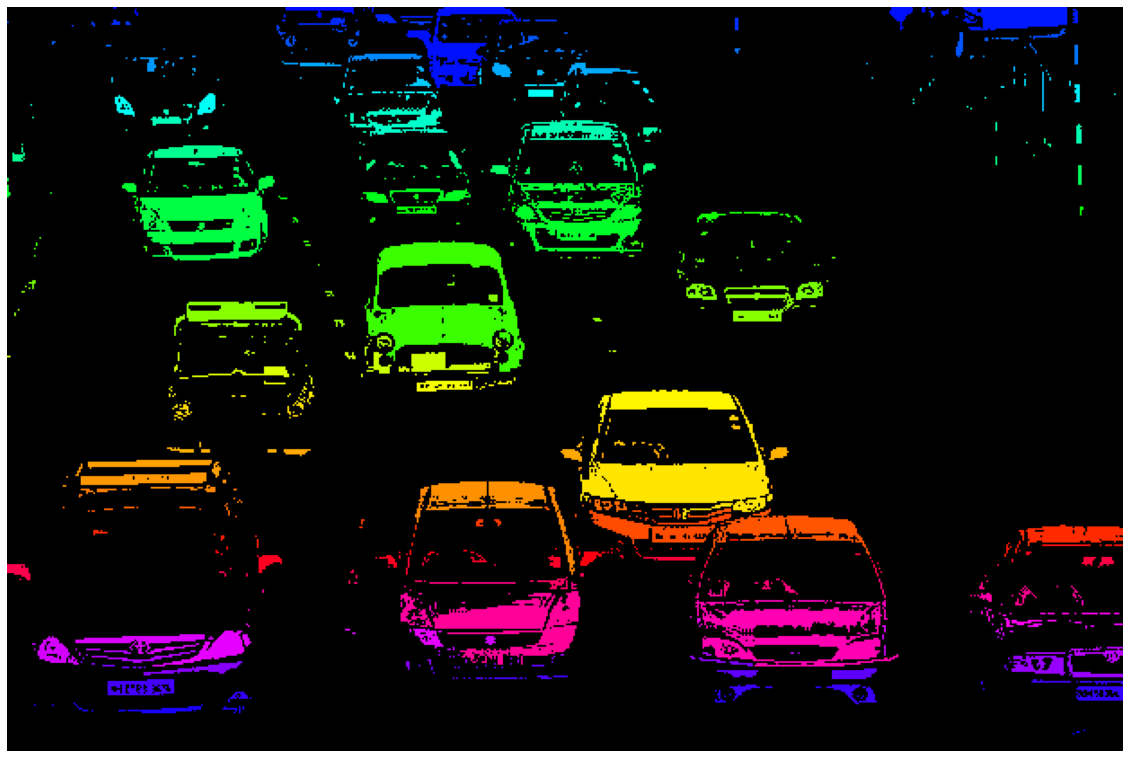

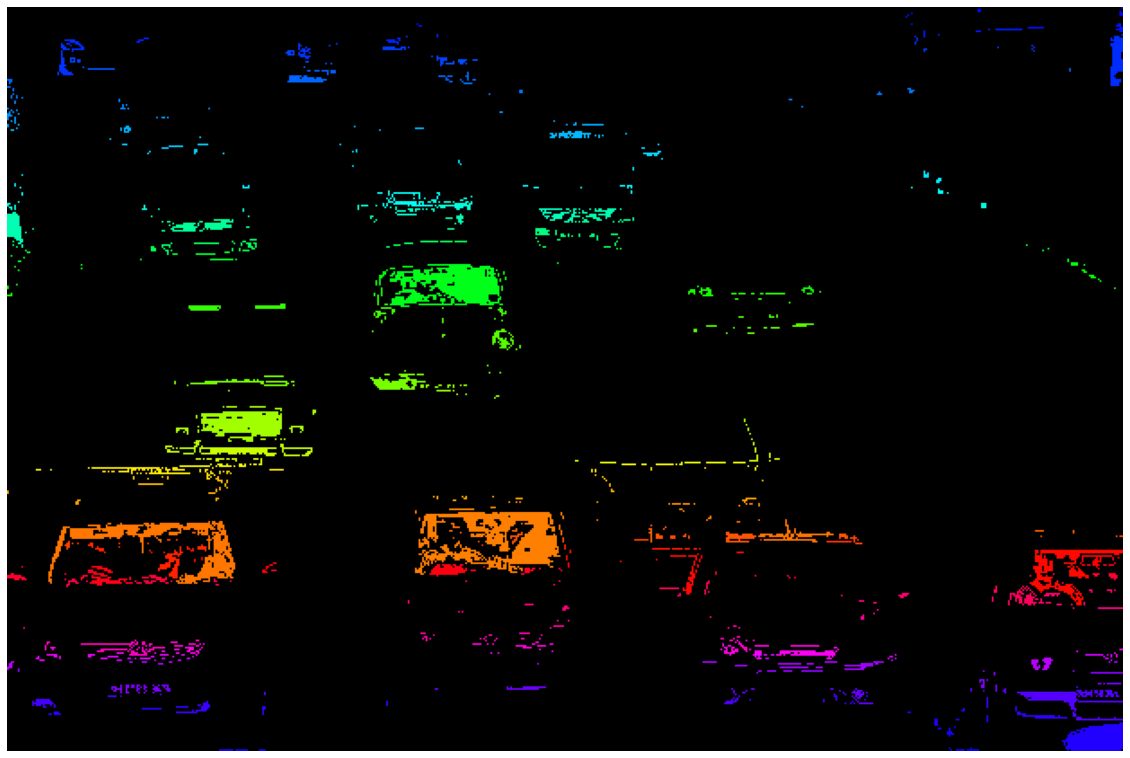

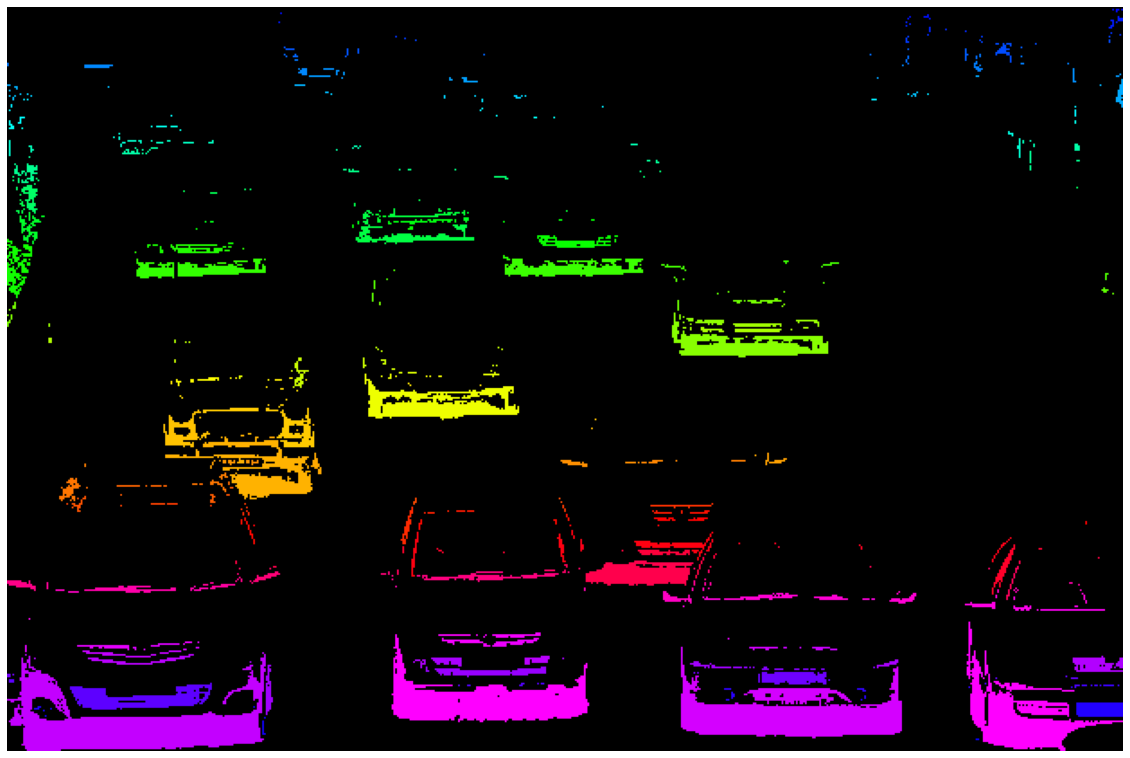

In [13]:
for each_image_index in range(len(all_CCL_clustered_images)):
    # print(each_image_index)
    each_image = all_CCL_clustered_images[each_image_index]
    # props(each_image, show_uniques=True) # Shape : (X, Y, 3) Maximum : 255 Minimum : 0 Data Type : uint8
    show_image(each_image, 
               title = f"CCL_image_cluster_{num_of_clustering}_{each_image_index}", 
               convert_BGR2RGB=False)

In [14]:
all_CCL_morphed_images = list(map(lambda x: run_morphological_external_transform(img_data = np.squeeze(x)), all_CCL_clustered_images))


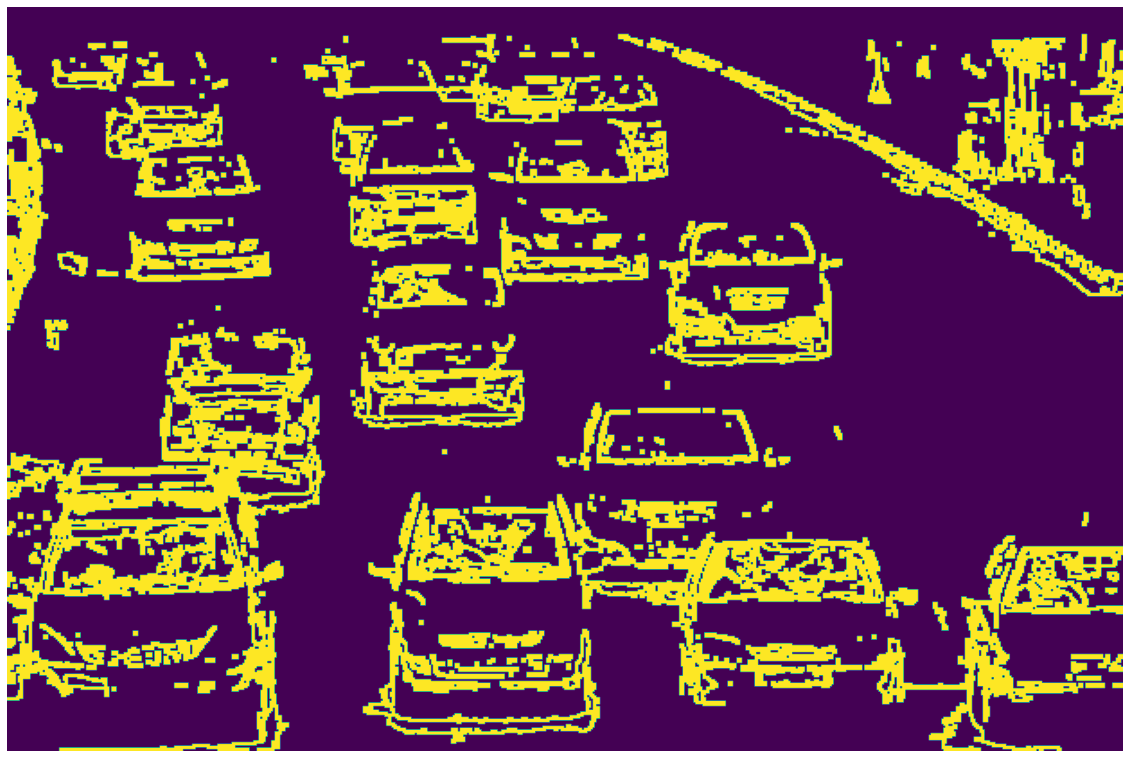

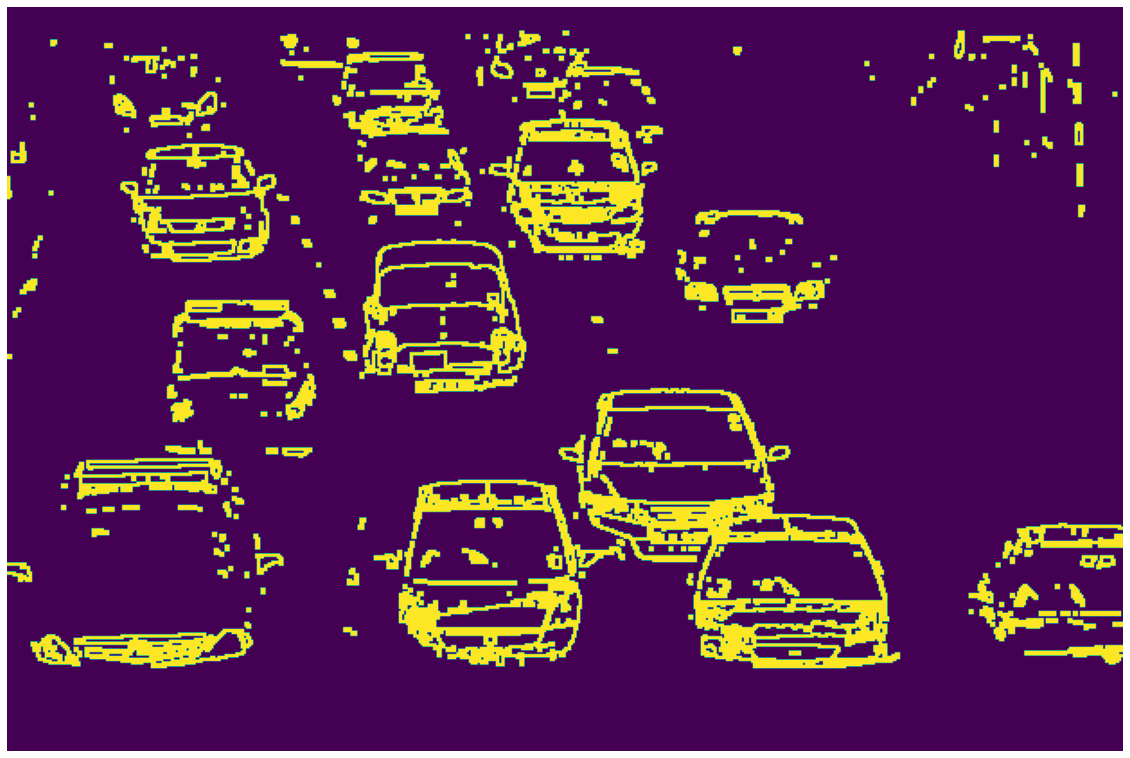

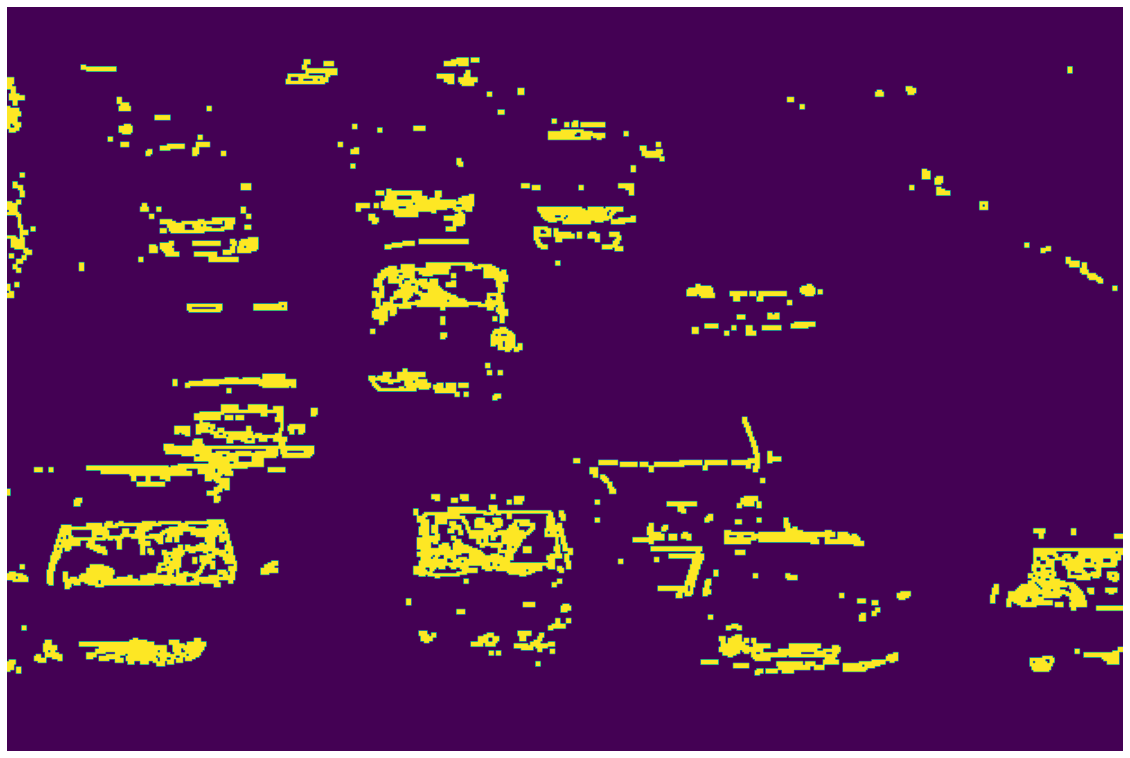

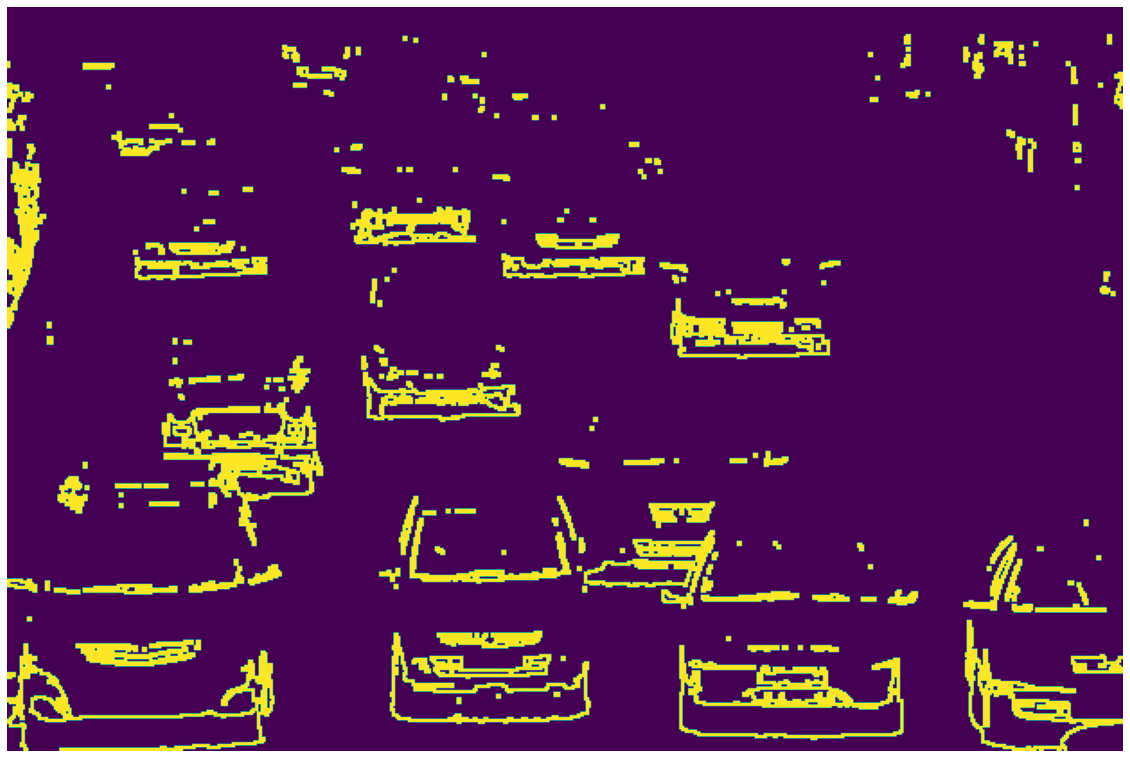

In [15]:
for each_image_index in range(len(all_CCL_morphed_images)):
    # print(each_image_index)
    each_image = all_CCL_morphed_images[each_image_index]
    # props(each_image, show_uniques=True) # Shape : (X, Y, 3) Maximum : 255 Minimum : 0 Data Type : uint8
    show_image(each_image, 
               title = f"CCL_Morphed_{num_of_clustering}_{each_image_index}", 
               convert_BGR2RGB=False)

Shape : (414, 621) Maximum : 255 Minimum : 0 Data Type : uint8


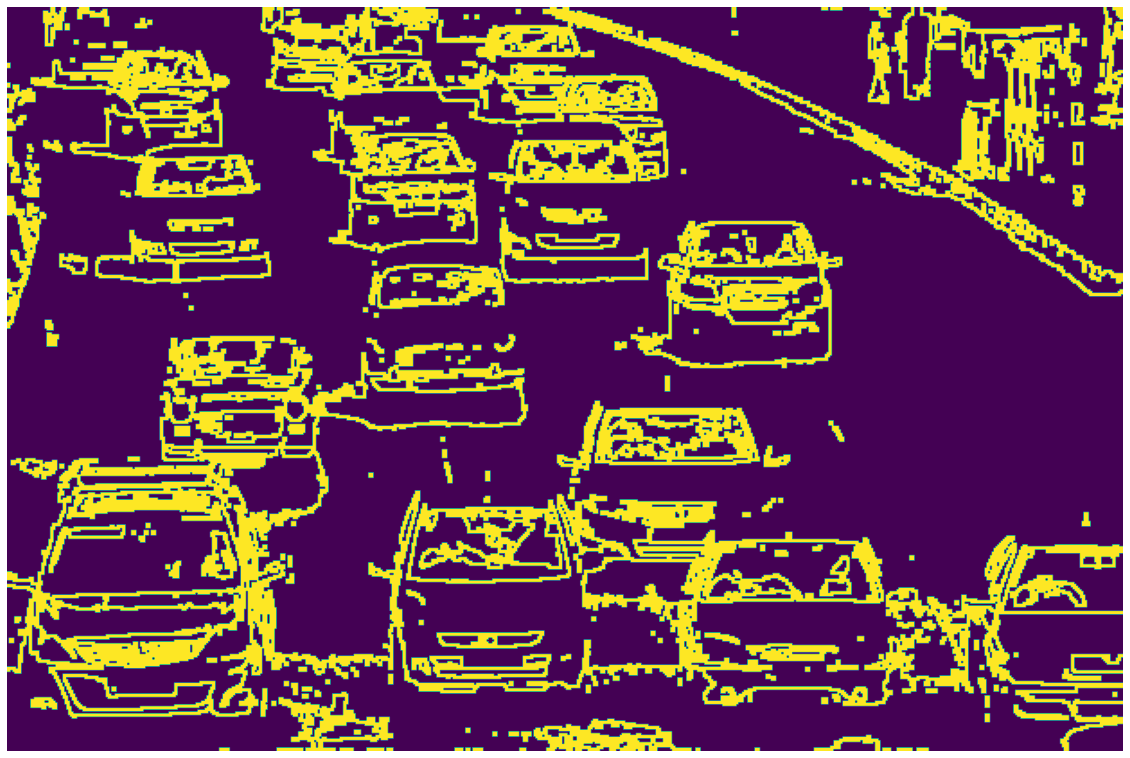

In [16]:
img_orig_morph = run_morphological_external_transform(img_data = img)
props(img_orig_morph)
show_image(img_orig_morph, title = "img_orig_morph")

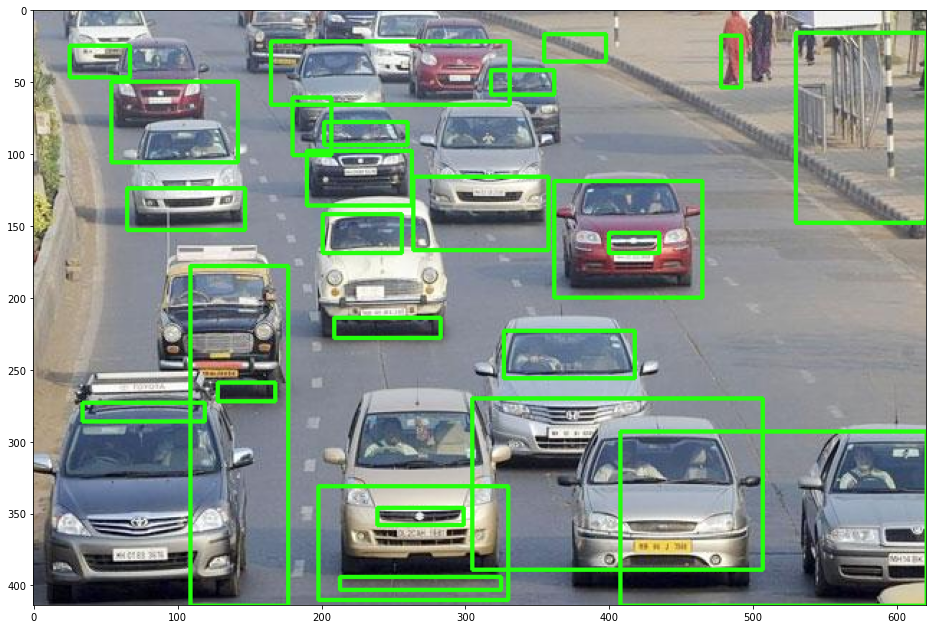

In [34]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(16,18))
# plt.imshow(img)

img_morpho = all_CCL_morphed_images[0]
# import cv2

# image = cv2.imread('1.png')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img_morpho, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)

# Find contours
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and draw rectangles around contours
THRESHOLD_AREA_PIXELS_SQ = 200 # 120
for c in cnts:
    if cv2.contourArea(c) > THRESHOLD_AREA_PIXELS_SQ:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)


plt.figure(figsize=(16,18))
plt.imshow(img)
# plt.imshow(image)
# cv2.imwrite('canny.png', canny)
# cv2.imwrite('image.png', image)
# cv2.waitKey(0)
# plt.imshow(img_morpho)

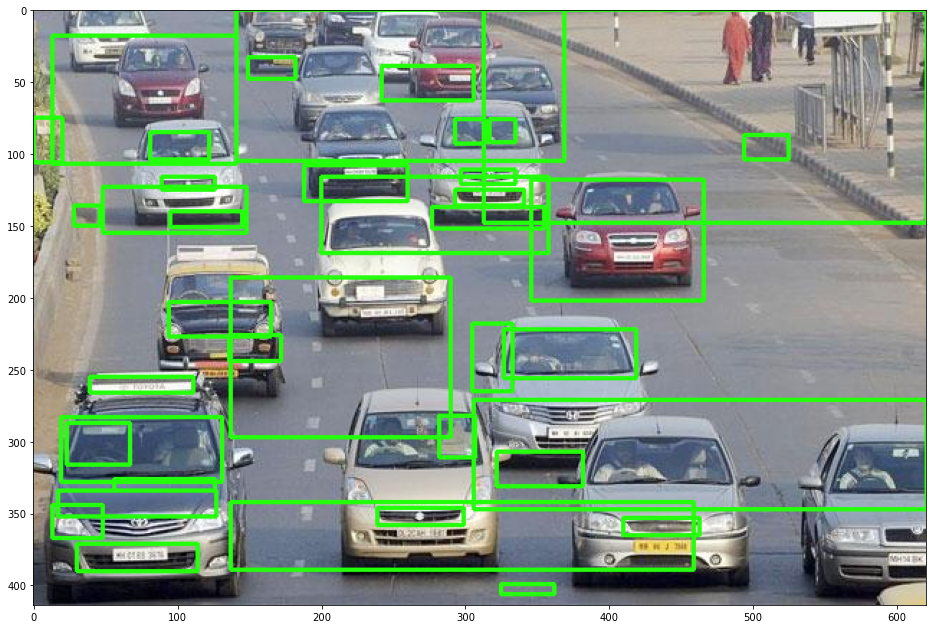

In [19]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(16,18))
# plt.imshow(img)

img_morpho = all_CCL_morphed_images[0]
# import cv2

# image = cv2.imread('1.png')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img_orig_morph, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)

# Find contours
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and draw rectangles around contours
for c in cnts:
    if cv2.contourArea(c) > 120:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)


plt.figure(figsize=(16,18))
plt.imshow(img)
# plt.imshow(image)
# cv2.imwrite('canny.png', canny)
# cv2.imwrite('image.png', image)
# cv2.waitKey(0)
# plt.imshow(img_morpho)

In [22]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
Areas = [cv2.contourArea(cnt) for cnt in cnts]
# for cnt in cnts:
#     approx = cv2.contourArea(cnt)
#     print(approx)

0.5


(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([5.0000000e-01, 2.3889750e+04, 4.7779000e+04, 7.1668250e+04,
        9.5557500e+04, 1.1944675e+05, 1.4333600e+05, 1.6722525e+05,
        1.9111450e+05, 2.1500375e+05, 2.3889300e+05]),
 <BarContainer object of 10 artists>)

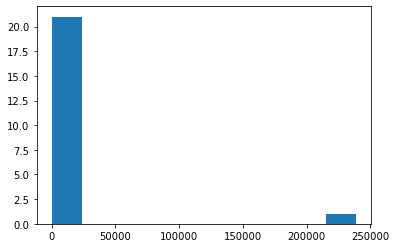

In [33]:
Filtered_Areas = list(filter(lambda x: x > 0.01, Areas))
print(min(Filtered_Areas))
plt.hist(Filtered_Areas)
